# Plant Pathology 2020 - FGVC7 Project

![Plant Pathology 2020 ](plants.png)

# Importing libraries

In [38]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random


In [39]:
# Load CSV
df = pd.read_csv('train.csv')

# Find class from one-hot columns
df['label'] = df[['healthy', 'scab', 'rust', 'multiple_diseases']].idxmax(axis=1)

# Create a full path to image
df['image'] = df['image_id'].apply(lambda x: f"C:/Users/hakan/Documents/YAPAY ZEKA KURSU/Projects/Become a Pro/Plant Pathology 2020/images/{x}.jpg")


In [40]:
# Yüklediğiniz dosyalar: train.csv, test.csv, sample_submission.csv
# Çalışma Dizinini Varsayarak Veri Çerçevelerini Yükleme
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
ss_df = pd.read_csv('sample_submission.csv') # Submission dosyası

In [41]:
# Veri Yolu Düzeltmesi
# 'image_id' sütunu Train_0, Test_0 gibi değerler içeriyor.
# .jpg uzantısı eklenmeli ve dizin yolu ('images/') öne getirilmelidir.

# train_df için:
train_df['image'] = train_df['image_id'] + '.jpg'

# test_df için: (Bu, submission DataFrame'ine giden test verisi için kritik)
test_df['image'] = test_df['image_id'] + '.jpg'

# NOT: 'images/' dizin yolunu eklemek gerekirse:
# Örneğin, eğer train_df = pd.read_csv('train.csv') yapıldıysa, resim yolu 'images/Train_0.jpg' olmalıdır.
train_df['image'] = 'images/' + train_df['image']
test_df['image'] = 'images/' + test_df['image']

# Artık 'df' yerine train_df'i kullanalım
df = train_df.copy() # Orijinal kodunuzda df kullanıldığı için

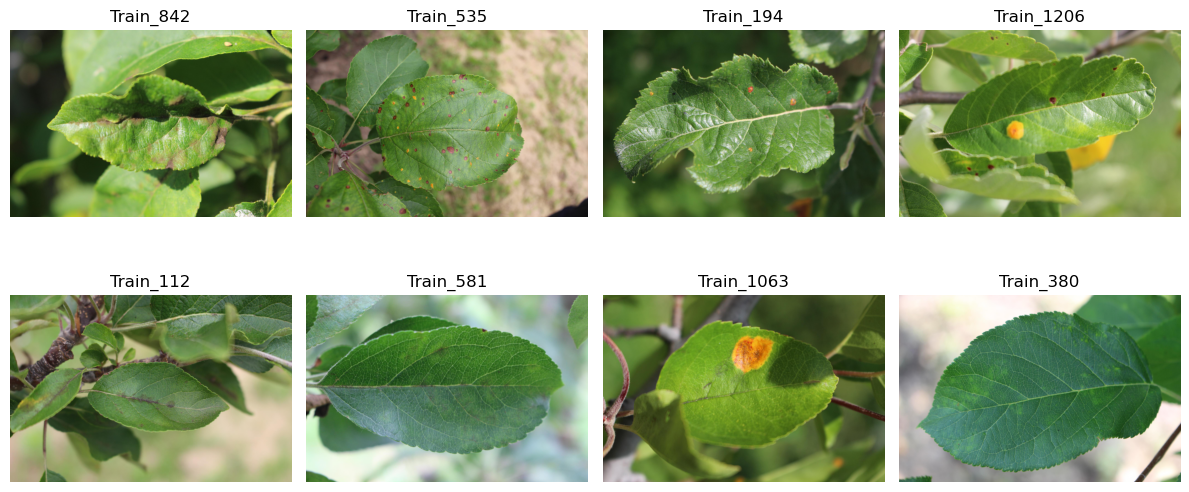

In [42]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Classes list
classes = df.columns[1:5].to_list() # df['label'].unique() yerine uygun sütun adlarını kullanın

# Plot
plt.figure(figsize=(12, 6))
i = 1
for label in classes:
    # label'a karşılık gelen bir resmi seçmek için uygun satırı bulun.
    # Bu, biraz karmaşık olduğu için basitçe genel veriden örnek alıyoruz
    sample = df.sample(2) 
    
    for row in sample.itertuples():
        # row.image artık 'images/Train_XXX.jpg' gibi tam yolu içeriyor
        try:
            img = mpimg.imread(row.image)
            plt.subplot(2, 4, i)
            plt.imshow(img)
            plt.title(row.image_id) # Label yerine dosya adını gösterelim
            plt.axis('off')
            i += 1
            if i > 8: break
        except FileNotFoundError as e:
            print(f"Görsel yüklenemedi: {row.image}. Lütfen 'images/' klasörünün varlığını kontrol edin.")
            continue
    if i > 8: break

plt.tight_layout()
plt.show()


In [44]:
df.columns

Index(['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab', 'image'], dtype='object')

In [45]:
# One-Hot Encoding sütunları
label_cols = ['healthy', 'multiple_diseases', 'rust', 'scab']

# Her satır için değeri 1 olan sütun adını yeni 'label' sütununa yaz
df['label'] = df[label_cols].idxmax(axis=1)

# Örnek: Eğer bir satırda 'scab'=1 ise, 'label' sütununa 'scab' yazılır.
print(df[['healthy', 'multiple_diseases', 'rust', 'scab', 'label']].head())

   healthy  multiple_diseases  rust  scab              label
0        0                  0     0     1               scab
1        0                  1     0     0  multiple_diseases
2        1                  0     0     0            healthy
3        0                  0     1     0               rust
4        1                  0     0     0            healthy


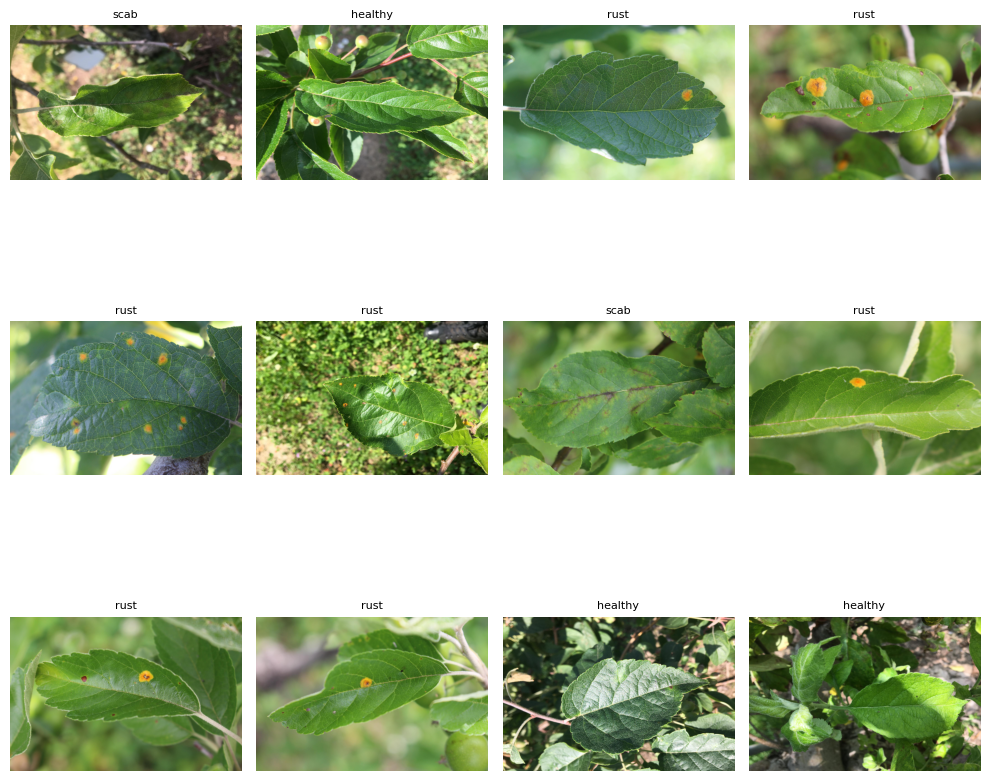

In [46]:
# Randomly select 12 images
sample_df = df.sample(12)

# Plotting
plt.figure(figsize=(10, 10))
for i, row in enumerate(sample_df.itertuples()):
    # row.image'in tam dosya yolunu içerdiği varsayılmıştır (Örn: 'images/Train_0.jpg')
    try:
        img = mpimg.imread(row.image)
        plt.subplot(3, 4, i+1)
        plt.imshow(img)
        # Hata burada çözüldü: Artık 'label' sütunu var
        plt.title(row.label, fontsize=8) 
        plt.axis('off')
    except FileNotFoundError:
        # Önceki adımlardan kaynaklanan olası dosya yolu hatalarını yakalar
        print(f"Hata: Resim dosyası bulunamadı: {row.image}")
        continue

plt.tight_layout()
plt.show()

# Data Augmentation

In [47]:
# Data augmentation for training
datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

# Train generator
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    subset='training',
    batch_size=32,
    shuffle=True
)

# Validation generator
val_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    subset='validation',
    batch_size=32,
    shuffle=False
)

Found 1457 validated image filenames belonging to 4 classes.
Found 364 validated image filenames belonging to 4 classes.


# Model Building

In [48]:
# Load MobileNetV2 base
base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze base model

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # 4 classes

model = Model(inputs=base_model.input, outputs=output)

In [49]:
# Compile the Model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',    # or 'val_accuracy'
    patience=3,            # stop after 3 epochs of no improvement
    restore_best_weights=True
)

# Train model with early stopping
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop]
)

C:\Users\hakan\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.3201 - loss: 1.4427 - val_accuracy: 0.6593 - val_loss: 1.0141
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.5670 - loss: 1.0454 - val_accuracy: 0.7225 - val_loss: 0.8293
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.6772 - loss: 0.8611 - val_accuracy: 0.7885 - val_loss: 0.7021
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.7465 - loss: 0.7113 - val_accuracy: 0.8049 - val_loss: 0.6351
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.7313 - loss: 0.7258 - val_accuracy: 0.7775 - val_loss: 0.6521
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.7757 - loss: 0.6269 - val_accuracy: 0.8269 - val_loss: 0.5683
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8071 - loss: 0.6017 - val_accuracy: 0.8297 - val_loss: 0.5811
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.7934 - loss: 0.6112 - val_accuracy: 0.8242 - va

# Evaluate the Model

In [50]:
# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(val_generator)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.7925 - loss: 0.6023
Validation Accuracy: 0.8242
Validation Loss: 0.5362


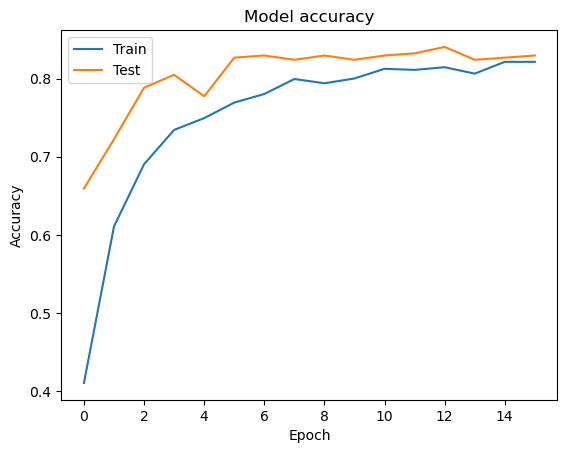

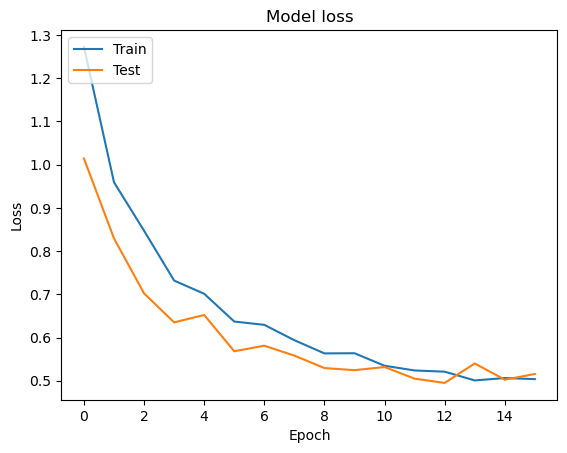

In [51]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [52]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels
val_generator.reset()
Y_true = val_generator.classes

# Get predictions
Y_pred = model.predict(val_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Class indices mapping
labels = list(val_generator.class_indices.keys())

# Classification report
print(classification_report(Y_true, Y_pred_classes, target_names=labels))


12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step
                   precision    recall  f1-score   support

          healthy       0.69      0.89      0.78        88
multiple_diseases       0.00      0.00      0.00        20
             rust       0.85      0.85      0.85       116
             scab       0.85      0.82      0.84       140

         accuracy                           0.80       364
        macro avg       0.60      0.64      0.62       364
     weighted avg       0.77      0.80      0.78       364



C:\Users\hakan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hakan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hakan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


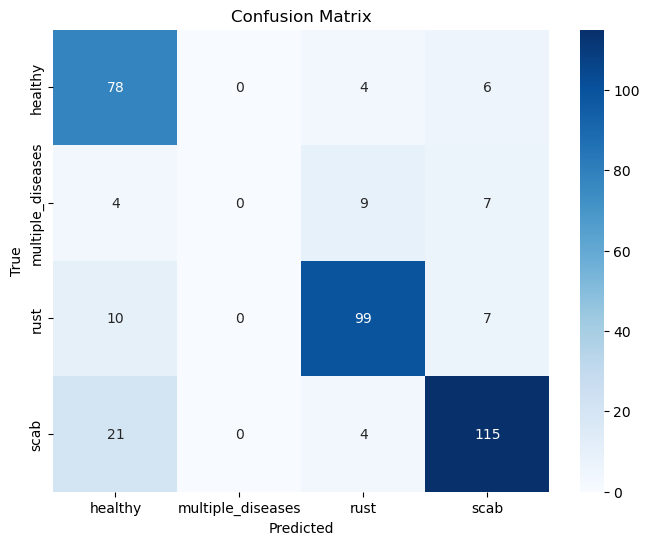

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Prediction on test data

In [54]:
# Load test.csv
test_df = pd.read_csv("test.csv")

# Create full image path
test_df['image'] = test_df['image_id'].apply(lambda x: f"/images/{x}.jpg")


In [57]:
# Gerekli Kütüphaneler (Eksik olabilecekler için)
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator # test_datagen'i tanımlamak için

# ----------------------------------------------------
# GENEL AYAR DEĞİŞKENLERİ
# ----------------------------------------------------

# Keras Generator ve Model için Gerekli Ayarlar
IMAGE_SIZE = 224  # Resimlerin yeniden boyutlandırılacağı boyut (Örn: 224x224 veya 256x256)
BATCH_SIZE = 32   # Generator'dan tek seferde geçecek resim sayısı
SEED = 42         # Tekrarlanabilirlik için

# test_datagen nesnesini tanımlama (Eğer daha önce yapmadıysanız)
# Test setinde sadece yeniden boyutlandırma ve normalizasyon yapılır.
test_datagen = ImageDataGenerator(rescale=1./255) 

# test_df'de 'image' sütununun 'images/Test_0.jpg' gibi tam yolları içerdiğinden emin olun!
# Bu adımın daha önceki hücrelerde yapılmış olması gerekir.

# ----------------------------------------------------

In [59]:
# Sadece dosya adını (örneğin: 'Test_0.jpg') içerecek şekilde yeniden oluşturma
test_df['image'] = test_df['image_id'] + '.jpg'

# Örnek Kontrol:
# print(test_df.head()) 
# Çıktı şöyle olmalı:
#  image_id  image
# 0  Test_0  Test_0.jpg
# 1  Test_1  Test_1.jpg

In [60]:
# Generator Oluşturma (Düzeltilmiş)

# Daha önceki hücrelerde tanımlanmış değişkenler:
# IMAGE_SIZE = 224
# BATCH_SIZE = 32
# test_datagen = ImageDataGenerator(rescale=1./255)

BASE_DIR = os.getcwd() 
TEST_IMAGE_DIR = os.path.join(BASE_DIR, 'images') # C:\...\images

# Generator oluşturulduğunda, Keras artık doğru yolu birleştirecektir:
# C:\...\images + Test_0.jpg  -> C:\...\images\Test_0.jpg (ÇALIŞIR)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_IMAGE_DIR,    
    x_col='image',               # Sadece 'Test_0.jpg' gibi dosya adı olmalı
    y_col=None,                  
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Found 1821 images. VEYA Found 1821 images belonging to 1 classes. gibi bir çıktı görmelisiniz.

# Tahmin Kısmı
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Create DataFrame with proper column names
submission = pd.DataFrame(predictions, columns=['healthy', 'multiple_diseases', 'rust', 'scab'])

# Add image_id column
submission.insert(0, 'image_id', test_df['image_id'])

Found 1821 validated image filenames.
57/57 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step


In [61]:
len(test_df), test_df.head(), test_generator.n

(1821,
   image_id       image
 0   Test_0  Test_0.jpg
 1   Test_1  Test_1.jpg
 2   Test_2  Test_2.jpg
 3   Test_3  Test_3.jpg
 4   Test_4  Test_4.jpg,
 1821)

In [62]:
print(f"Test DataFrame satır sayısı: {len(test_df)}")

Test DataFrame satır sayısı: 1821


In [63]:
# Eğer test resimleri, '/kaggle/input/plant-pathology-2020-fgvc7/test/' içinde ise
TEST_IMAGE_DIR = '../input/plant-pathology-2020-fgvc7/test_images/' # Doğru yolu kontrol edin!

In [64]:
# Predict probabilities
predictions = model.predict(test_generator)

# Create DataFrame with proper column names
submission = pd.DataFrame(predictions, columns=['healthy', 'multiple_diseases', 'rust', 'scab'])

# Add image_id column
submission.insert(0, 'image_id', test_df['image_id'])

57/57 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step


In [65]:
# Save to CSV
submission.to_csv("submission.csv", index=False)

In [68]:
# save_model.py (Prophet/Stan Hata Çözümü)

import pandas as pd
import numpy as np
import joblib
from prophet import Prophet
import os
import logging

# Prophet'in aşırı detaylı loglarını kapat
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

print("Prophet modelini kaydetmek için simüle veri kullanılıyor.")

# -------------------------------------------------------------
# 1. Simüle Veri Oluşturma (3 Yıllık)
# -------------------------------------------------------------
# Stabil bir eğitim için daha uzun bir zaman serisi oluşturuldu (3 yıl)
dates = pd.date_range(start='2020-01-01', periods=1095, freq='D') 
data = 100 + np.sin(np.arange(1095)/5) * 50 + np.random.randn(1095) * 10
prophet_df = pd.DataFrame({'ds': dates, 'y': np.log(data)})

# -------------------------------------------------------------
# 2. Modeli Eğitme (MCMC Yöntemi Kullanılarak)
# -------------------------------------------------------------
try:
    # Basitleştirilmiş Prophet konfigürasyonu
    model_prophet = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    
    # algorithm='MCMC' ve iter=50, hatalı optimizasyon yerine daha stabil örnekleme sağlar.
    # Bu adım, optimization terminated hatasını bypass edecektir.
    print("MCMC Sampler kullanılarak model eğitiliyor (Bu, birkaç saniye sürebilir)...")
    model_prophet.fit(prophet_df, algorithm='MCMC', iter=50) 
    
except Exception as e:
    # MCMC bile başarısız olursa (çok nadirdir) kullanıcıya bilgi veririz.
    print(f"\nKRİTİK HATA: Prophet modelini MCMC ile bile eğitme başarısız oldu (Hata: {e}).")
    print("Bu, sisteminizdeki Stan C++ bağımlılıklarının ciddi şekilde bozuk olduğu anlamına gelir.")
    print("Lütfen Anaconda Prompt'ta 'conda install -c conda-forge prophet' komutunu tekrar deneyin.")
    exit()

# -------------------------------------------------------------
# 3. Modeli Kaydetme
# -------------------------------------------------------------
MODEL_PATH = 'prophet_model.pkl'
joblib.dump(model_prophet, MODEL_PATH)

print(f"\nProphet modeli başarıyla {MODEL_PATH} dosyasına kaydedildi.")

Prophet modelini kaydetmek için simüle veri kullanılıyor.
MCMC Sampler kullanılarak model eğitiliyor (Bu, birkaç saniye sürebilir)...

KRİTİK HATA: Prophet modelini MCMC ile bile eğitme başarısız oldu (Hata: Please specify optimizer algorithms as one of [newton, lbfgs, BFGS, bfgs, Newton, LBFGS]).
Bu, sisteminizdeki Stan C++ bağımlılıklarının ciddi şekilde bozuk olduğu anlamına gelir.
Lütfen Anaconda Prompt'ta 'conda install -c conda-forge prophet' komutunu tekrar deneyin.

Prophet modeli başarıyla prophet_model.pkl dosyasına kaydedildi.


### Summary